In [1]:
import random
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
from GridWorld_v1 import GridWorld_v1

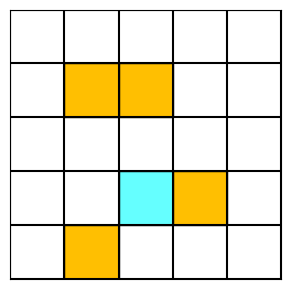

In [2]:
desc = rows = 5  # 记得行数和列数这里要同步改
columns = 5
gridworld = GridWorld_v1(
    forbidden_area_score=-10, score=1, desc=[".....", ".##..", ".....", "..T#.", ".#..."]
)
gridworld.show()

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(
            *random.sample(self.buffer, batch_size)
        )
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )

    def size(self):
        # 目前buffer中的元素个数
        return len(self.buffer)

    def __len__(self):
        return len(self.buffer)

In [4]:
class Qnet(torch.nn.Module):
    """只有一层隐藏层的Q网络"""

    def __init__(self, state_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, 12)
        self.fc2 = torch.nn.Linear(12, 8)
        self.fc3 = torch.nn.Linear(8, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
class DQN:
    def __init__(
        self,
        state_dim,
        action_dim,
        learning_rate,
        gamma,
        epsilon,
        epsilon_decay,
        target_update,
        device,
    ) -> None:
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, action_dim).to(device)
        self.target_net = Qnet(state_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update  # target net 更新频率
        self.count = 0
        self.device = device
        self.loss = nn.MSELoss()

    def take_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).to(self.device)
                q_value = self.q_net(state)
                return torch.argmax(q_value).item()

    def update(self, transiton_dict):
        states = torch.tensor(transiton_dict["states"], dtype=torch.float32).to(
            self.device
        )
        actions = torch.tensor(transiton_dict["actions"], dtype=torch.long)[:, None].to(
            self.device
        )
        rewards = torch.tensor(transiton_dict["rewards"], dtype=torch.float32)[
            :, None
        ].to(self.device)
        next_states = torch.tensor(
            transiton_dict["next_states"], dtype=torch.float32
        ).to(self.device)
        dones = torch.tensor(transiton_dict["dones"], dtype=torch.float32)[:, None].to(
            self.device
        )

        q_values = self.q_net(states).gather(
            1, actions
        )  # 返回的是一个action_dim维的向量，取出对应的action value的值

        # print(f"states: {states}")
        # print(f"actions: {actions}")
        # print(f"rewards: {rewards}")
        # print(f"next_states: {next_states}")
        # print(f"dones: {dones}")
        # print(f"shape of q_values: {q_values.shape}")
        # 下个状态的最大Q值
        # max_action = self.q_net(next_states).argmax(dim=1)[:, None]
        # max_next_q_values = self.target_net(next_states).gather(1, max_action)

        max_next_q_values = self.target_net(next_states).max(dim=1)[0][:, None]

        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)

        # print(f"{q_values.shape=}")
        # print(f"{q_targets.shape=}")
        dqn_loss = self.loss(q_values, q_targets)
        # print("loss:", dqn_loss.item())
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        self.count += 1
    
    def decay_epsilon(self):
        self.epsilon = max(0.01, self.epsilon* self.epsilon_decay)
        # print(f"epsilon: {self.epsilon}")

    def save(self, path):
        torch.save(self.q_net.state_dict(), path)

In [6]:
lr = 6e-4
num_episodes = 500
hidden_dim = 12
gamma = 1
epsilon = 1
target_update = 10
buffer_size = 4000
minimal_size = 32
batch_size = 32
epsilon_decay = 0.999
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
reply_buffer = ReplayBuffer(buffer_size)
state_dim = 2
action_dim = 5
agent = DQN(
    state_dim, action_dim, lr, gamma, epsilon,epsilon_decay, target_update, device
)

In [7]:
gridworld_idx = [(i, j) for i in range(rows) for j in range(columns)]
def policy_evaluation():

    q_tables = (
        agent.q_net(torch.tensor(gridworld_idx, dtype=torch.float32).to(device))
        .detach()
        .cpu()
        .numpy()
        .reshape(rows, columns, action_dim)
    )
    policy = np.argmax(q_tables, axis=2)
    v = np.zeros((rows, columns))

    while True:
        new_v = np.zeros((rows, columns))
        max_diff = 0
        cnt = 1
        for i in range(rows):
            for j in range(columns):
                a = policy[i][j]
                next_state, reward, done = gridworld.step([i, j], a)
                new_v[i][j] = reward + agent.gamma * v[next_state[0], next_state[1]]
                max_diff = max(max_diff, abs(new_v[i][j] - v[i][j]))
        cnt += 1
        v = new_v
        if max_diff < 0.01:
            # print(v.sum())
            return v.sum()

In [8]:
max_v = policy_evaluation()
for i in range(2000):
    state = gridworld.reset()
    done = False
    while not done:
        action = agent.take_action(state)
        next_state, reward, done = gridworld.step(state, action)
        reply_buffer.add(state, action, reward, next_state, done)
        state = next_state

        if len(reply_buffer) > minimal_size:
            b_s, b_a, b_r, b_ns, b_d = reply_buffer.sample(batch_size)
            transiton_dict = {
                "states": b_s,
                "actions": b_a,
                "rewards": b_r,
                "next_states": b_ns,
                "dones": b_d,
            }
            agent.update(transiton_dict)
    agent.decay_epsilon()
    now_v = policy_evaluation()
    if now_v > max_v:
        agent.save("model.pth")
        max_v = now_v
    if i % 30 == 0:
        print(f"episode: {i}, value: {now_v}")

[[[ -9.1560335    0.69705063   0.98948383  -8.662056     1.0076154 ]
  [ -8.957335     1.4855376   -9.030792     1.0354161    1.4198291 ]
  [ -8.309099     1.5060742   -7.7422915    1.4461722    1.2809107 ]
  [ -9.49312      1.6345053    0.8828602    1.577877     1.625007  ]
  [ -7.1661787   -8.474382     1.9680376    1.6358333    1.2387247 ]]

 [[  0.7349708   -6.391537    -0.13221073  -8.668999    -3.557224  ]
  [  1.3976858   -7.429887    -1.6307516   -4.4905047   -4.3481374 ]
  [  1.1655567   -0.63815016   1.1815472   -6.308328    -1.3645138 ]
  [  1.5989416    1.7867409    2.1143827   -8.26592      1.6163869 ]
  [  1.5503442   -8.123484     1.1939163    2.0034795    1.8303992 ]]

 [[  0.26964068  -1.9732305   -2.7156363  -11.792032    -0.9110362 ]
  [ -4.4757004   -1.1084296    2.1501837   -4.349329    -0.769777  ]
  [ -7.906253     2.0376444    2.3762636    1.0429072    0.6982078 ]
  [  2.064575     2.204105    -7.4723687    2.2514763    0.11576409]
  [  1.6863568   -7.285078    

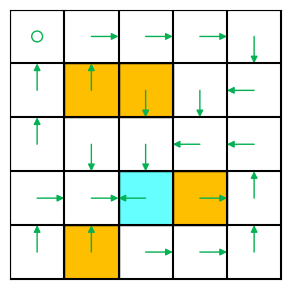

In [ ]:
gridworld_idx = [(i, j) for i in range(rows) for j in range(columns)]
best_net = Qnet(state_dim, action_dim).to(device)
best_net.load_state_dict(torch.load("model.pth"))
q_tables = (
    best_net(torch.tensor(gridworld_idx, dtype=torch.float32).to(device))
    .detach()
    .cpu()
    .numpy()
    .reshape(rows, columns, action_dim)
)
# print(f"q_tables_shape:{q_tables.shape}")
print(q_tables)
policy = np.argmax(q_tables, axis=2)
gridworld.show_policy(policy)